<a href="https://colab.research.google.com/github/juanagustinmasi/VacunarTech/blob/main/TP3/Cuaderno_1_martes_grupo6_2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1Introducción**
Mean filtering: El filtrado medio es un método de filtrado lineal, que reemplaza el valor de gris de píxel del centro punto de la ventana por medio de un píxel de ventana suave.

Dada una imagen f(i,j), el procedimiento consiste en generar una nueva imagen g(i,j) cuya intensidad para cada píxel se obtiene promediando los valores de intensidad de los píxeles f(i,j) incluidos en un entorno de vecindad predefinido.

En pocas palabras, es tomar el promedio de los valores de píxeles en un área determinada en lugar del valor de píxeles original.

# **2Armado del ambiente**
Instalación de pycuda y PyOpenCl

In [2]:
!pip install pycuda

     |████████████████████████████████| 1.7MB 33.1MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 81kB 11.6MB/s 
     |████████████████████████████████| 71kB 10.3MB/s 
  Created wheel for pycuda: filename=pycuda-2021.1-cp37-cp37m-linux_x86_64.whl size=627583 sha256=c3be25d053956593158067f10832986a75bb6faed9d537e4632eeef8588e7f68
  Stored in directory: /root/.cache/pip/wheels/d5/55/64/fd4dddcc5f1c25eebd90b5291c3769101dc978c70165685512
Successfully built pycuda
  Created wheel for pytools: filename=pytools-2021.2.7-py2.py3-none-any.whl size=60644 sha256=b9c306b34e0b156fb0e1b994fc5124f07bcd99996de424dd6819529134d7af3a
  Stored in directory: /root/.cache/pip/wheels/a0/b5/e5/e65d25997fd77729b9aa214645add18688483e48bbcbab6ffc
Successfully built pytools


In [4]:
pip install pyopencl

     |████████████████████████████████| 880kB 9.4MB/s 


# 2.2Lectura de imagen de dominio publico

In [11]:
#@title # 2.2.1 Parámetros de ejecución
#@markdown ---
#@markdown ### Especifique la URL de la imagen:
url_imagen = "https://cms-assets.tutsplus.com/uploads/users/1181/posts/29202/image/saltandpeppernoise.jpg" #@param {type:"string"}

#@markdown ---
# Verificamos que haya escrito una URL valida
if not (type(url_imagen) is str) or (url_imagen == ""):
  raise TypeError("Se tiene que ingresar una URL valida")


!wget {url_imagen} -O imagen.jpg

--2021-07-05 23:42:30--  https://cms-assets.tutsplus.com/uploads/users/1181/posts/29202/image/saltandpeppernoise.jpg
Resolving cms-assets.tutsplus.com (cms-assets.tutsplus.com)... 104.17.233.79, 104.17.234.79
Connecting to cms-assets.tutsplus.com (cms-assets.tutsplus.com)|104.17.233.79|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168013 (164K) [image/jpeg]
Saving to: ‘imagen.jpg’

imagen.jpg          100%[===================>] 164.08K  --.-KB/s    in 0.004s  

2021-07-05 23:42:30 (39.8 MB/s) - ‘imagen.jpg’ saved [168013/168013]



# **3.Desarrollo**

# **3.1Procesamiento y filtrado de imágen utilizando CPU** 
Se utilizó la API OpenCV-Python, destinado a hacer que el procesamiento regular de imágenes sea rápido y portátil. Estos dos objetivos se logran mediante la introducción de un nuevo modelo de ejecución basado en gráficos

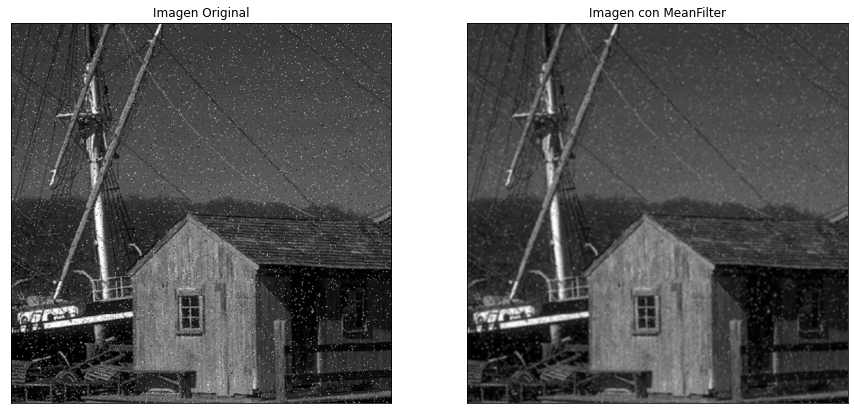

In [12]:
import os
os.environ['OPENCV_IO_MAX_IMAGE_PIXELS']=str(2**64)
import cv2
import numpy as np
from matplotlib import pyplot as plt


img = cv2.imread(r'imagen.jpg')

kernel = np.ones((5,5),np.float32)/25
dst = cv2.filter2D(img,-1,kernel)


#Mostrar imagen
plt.figure(figsize = (15, 10))
plt.subplot(121),plt.imshow(img),plt.title('Imagen Original'),plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(dst),plt.title('Imagen con MeanFilter'),plt.xticks([]), plt.yticks([])
plt.show()



# **3.2 (Desarrollo GPU) Mean Filter utilizando CUDA**
Ahora realizamos el mismo procedimiento de filtrado de la media pero basado en la computación paralela de la GPU. El resultado final del experimento muestra que el método propuesto funciona de manera más eficiente en comparación con el método tradicional de la CPU

Imagen del filtro: imagen.jpg -RGB- [850, 850]
Thread: [ 16 , 19  ], Bloque : [ 54 , 45 ]
Total de Thread: [ 864 , 855  ]  =  738720
Tiempo TOTAL:  371.791 [ms]
Tiempo GPU  :  0.357 [ms]


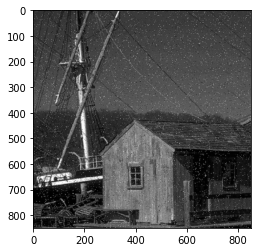

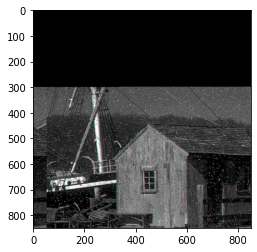

In [18]:
%matplotlib inline
from datetime import datetime
tiempo_total = datetime.now()

import matplotlib.pyplot as plt
import numpy
import numpy as np
from PIL import Image 
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule

# --------------------------------------------
# Definición de función que transforma el tiempo en  milisegundos 
tiempo_en_ms = lambda dt:(dt.days * 24 * 60 * 60 + dt.seconds) * 1000 + dt.microseconds / 1000.0
# --------------------------------------------

img_nombre = r'imagen.jpg'
image = Image.open( img_nombre ) 
  
# summarize some details about the image 
img_ancho, img_alto  = image.size 

# Convierto la imagen comprimida en JPEG/PNG a array
img_O_cpu = numpy.asarray(image)
img_O_cpu = img_O_cpu.astype( numpy.int32() )
img_R_cpu = numpy.empty_like( img_O_cpu)

# Reservo los 2 vectores en GPU(3 pixeles usa RGB * (el tamaño del array))
img_O_gpu = cuda.mem_alloc( img_O_cpu.nbytes )
img_R_gpu = cuda.mem_alloc( img_R_cpu.nbytes )

# GPU - Copio la memoria al GPU.
cuda.memcpy_htod( img_O_gpu, img_O_cpu )
cuda.memcpy_htod( img_R_gpu, img_R_cpu )

# CPU - Defino la función kernel que ejecutará en GPU.
module = SourceModule("""
__global__ void kernel_meanFilter(unsigned char* raw_image, unsigned char* filtered_image, int img_width, int img_height, int window_size)
{
	int j = blockIdx.x * blockDim.x + threadIdx.x;
    int i = blockIdx.y * blockDim.y + threadIdx.y;
	
	int half_window = (window_size - 1) / 2;
	
	if (i < img_height && j < img_width)
	{
		int left_limit, right_limit, top_limit, bottom_limit;
			
		if(j - half_window >= 0){
			left_limit = j-half_window;
		}else{
			left_limit = 0;
		}
			
        if(j + half_window <= img_width-1){
			right_limit = j + half_window;
		}else{
			right_limit = img_width-1;
		}
			
		if(i - half_window >= 0){
			top_limit = i - half_window;
		}else{
			top_limit = 0;
		}
			
        if(i + half_window <= img_height-1){
			bottom_limit = i + half_window;
		}else{
			bottom_limit = img_height-1;
		}
		
		double sum = 0;
		for(int k = top_limit; k <= bottom_limit; k++)
		{
			for(int m = left_limit; m <= right_limit; m++)
			{
				sum += raw_image[(k * img_height) + m];
			}
		}
		int current_window_size = (bottom_limit - top_limit + 1) * (right_limit - left_limit + 1);
		filtered_image[i*img_height + j] = sum / current_window_size;
	}
}

""") 

# Muestro los atributos de la imagen y como se ve antes del seudo filtro.
print("Imagen del filtro: " + img_nombre + " -" + image.mode + "- [" + str(img_ancho) + ", " + str(img_alto ) + "]" )  

# CPU - Genero la función kernel.
kernel = module.get_function("kernel_meanFilter")

tiempo_img = datetime.now()

dim_hilo_x = 16
dim_bloque_x = numpy.int( (img_ancho+dim_hilo_x-1) / dim_hilo_x )

dim_hilo_y = 19
dim_bloque_y = numpy.int( (img_alto+dim_hilo_y-1) / dim_hilo_y )

print( "Thread: [", dim_hilo_x, ",", dim_hilo_y, " ], Bloque : [", dim_bloque_x, ",", dim_bloque_y, "]" )
print( "Total de Thread: [", dim_hilo_x*dim_bloque_x, ",", dim_hilo_y*dim_bloque_y, " ]", " = ", dim_hilo_x*dim_bloque_x*dim_hilo_y*dim_bloque_y )

tiempo_img = datetime.now()

kernel( numpy.int32(img_ancho), numpy.int32(img_alto), img_O_gpu, img_R_gpu, block=( dim_hilo_x, dim_hilo_y, 1 ), grid=(dim_bloque_x, dim_bloque_y,1) )

tiempo_img = datetime.now() - tiempo_img

# GPU - Copio el resultado desde la memoria GPU.
cuda.memcpy_dtoh( img_R_cpu, img_R_gpu )

# Muestro la imagen Original el filtro.
plt.figure()
imgplot=plt.imshow( img_O_cpu )

# Muestro la imagen luego de aplicarle el filtro.
plt.figure()
imgplot=plt.imshow( img_R_cpu )

tiempo_total = datetime.now() - tiempo_total

print("Tiempo TOTAL: ", tiempo_en_ms( tiempo_total ), "[ms]" )
print("Tiempo GPU  : ", tiempo_en_ms( tiempo_img ), "[ms]" )

